In [71]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import c
c = c.value*1e-6
%matplotlib inline
from scipy.fftpack import fft, fftfreq
from scipy.signal import fftconvolve
from scipy.interpolate import splev, splrep

In [38]:
def sincfit(x, A, B, C, D):
    return A*(np.sinc(B*x+C))*np.cos(D*x)
def envelope(x, A, B, C):
    return A*(np.sinc(B*x+C))
def oscillation(x, D):
    return np.cos(D*x)
params = [-1.79425356e-04,   1.07657567e-01,  -4.17755798e+01, 6.20927874] 
bandwidth = (c/2)*params[1]
nu_0 = c*params[-1]/(4*np.pi)
print ("The bandwidth is {0:3.2f} GHz".format(bandwidth))
print ("The center of bandwidth is {0:3.2f} GHz".format(nu_0))

The bandwidth is 16.14 GHz
The center of bandwidth is 148.13 GHz


In [3]:
x = np.r_[180:580:10000j]
y = sincfit(x, *params)

In [4]:
geteven = lambda x: 0.5*(x[1:] + x[::-1][:-1])
getodd = lambda x: 0.5*(x[1:] - x[::-1][:-1])

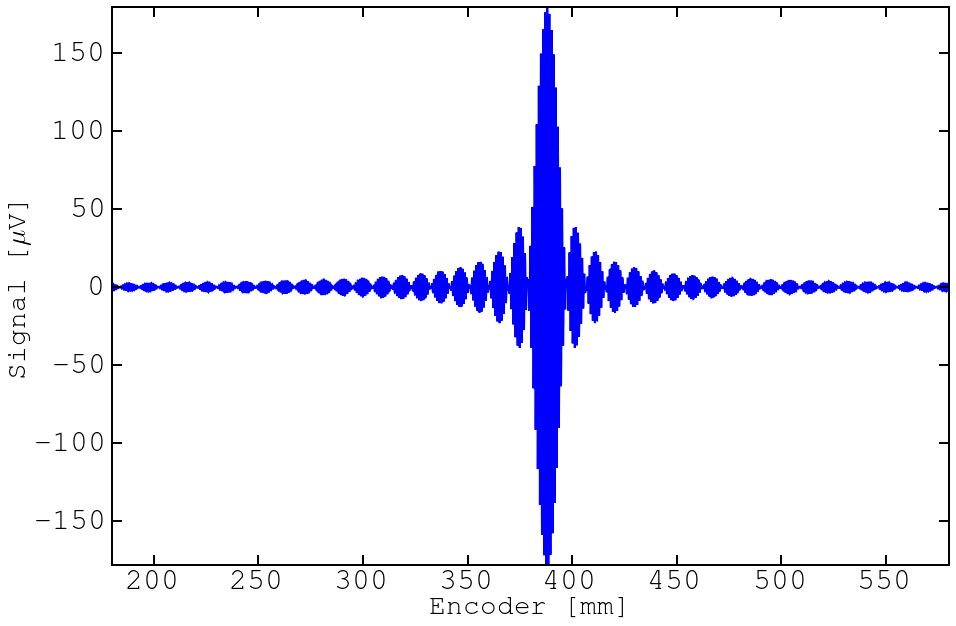

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(x, y*1e6)
ax.axis('tight')
ax.set_xlabel(r'Encoder [mm]')
ax.set_ylabel(r'Signal [$\mu$V]')
ax.set_xticklabels(['{0:3.0f}'.format(t) for t in ax.get_xticks()])
ax.set_yticklabels(['{0:3.0f}'.format(t) for t in ax.get_yticks()]);

In [6]:
phaseshift = np.round(((-params[2]/params[1])*params[-1])/np.pi)
peak =  (np.pi/params[-1])*phaseshift
print (peak)
delta = (peak - (-params[2]/params[1]))*(2/c)
print (delta)
pd = (x - peak)*(2/c)

388.064647474
0.000155909616665


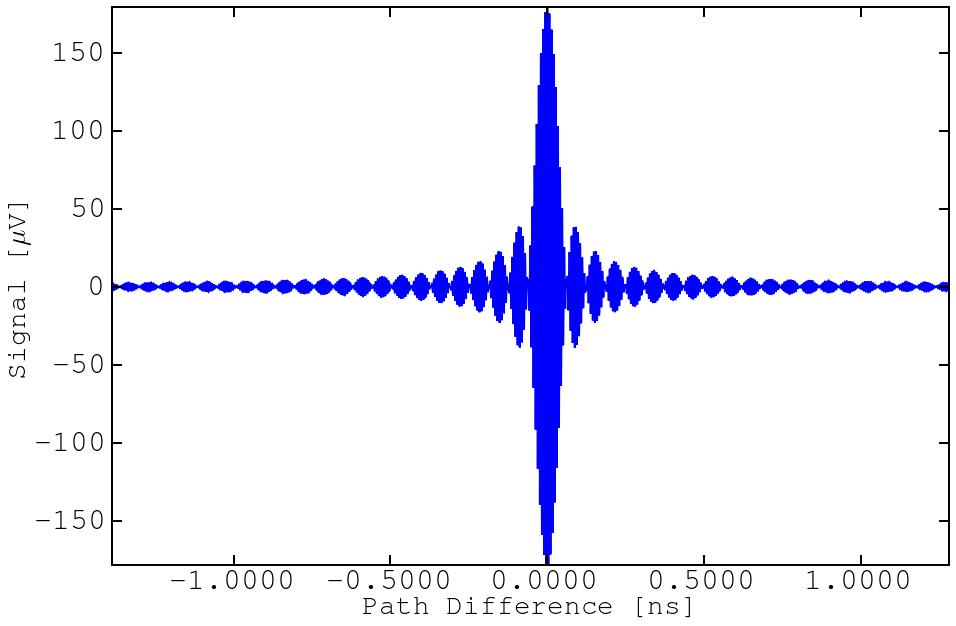

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(pd, y*1e6)
ax.axis('tight')
ax.set_xlabel(r'Path Difference [ns]')
ax.set_ylabel(r'Signal [$\mu$V]')
ax.set_xticklabels(['{0:0.4f}'.format(t) for t in ax.get_xticks()])
ax.set_yticklabels(['{0:3.0f}'.format(t) for t in ax.get_yticks()]);

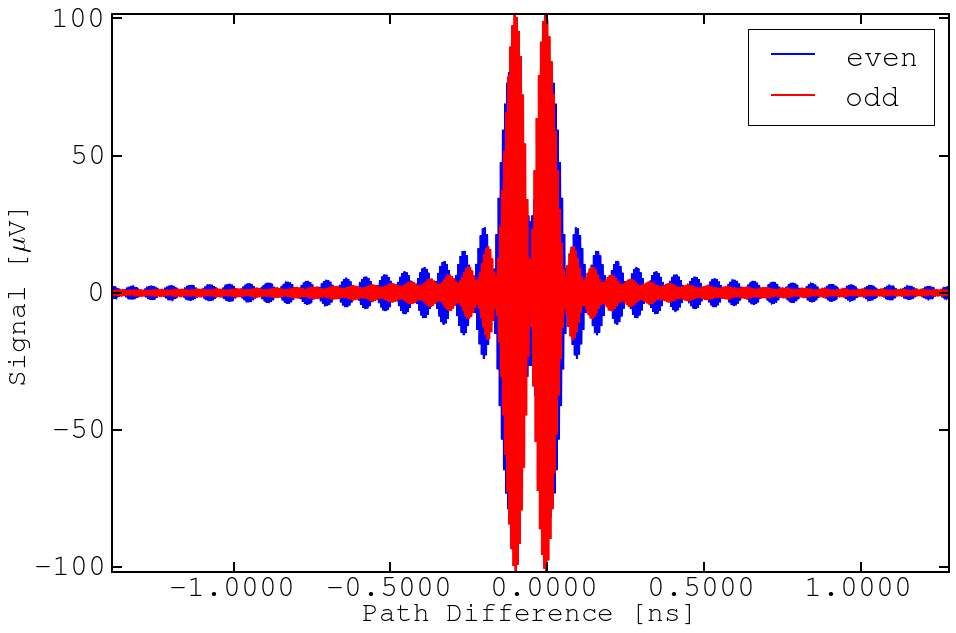

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(pd[1:], geteven(y)*1e6, 'b', label='even')
ax.plot(pd[1:], getodd(y)*1e6, 'r', label='odd')
ax.axis('tight')
ax.set_xlabel(r'Path Difference [ns]')
ax.set_ylabel(r'Signal [$\mu$V]')
ax.legend(loc='best')
ax.set_xticklabels(['{0:0.4f}'.format(t) for t in ax.get_xticks()])
ax.set_yticklabels(['{0:3.0f}'.format(t) for t in ax.get_yticks()]);

In [59]:
n = 12
k = 2.0
dx  = k*2**(1 - n)
pdnew = dx * np.arange(0, 2**n + 1) - k
pdnew = pdnew[:-1]

In [60]:
tck, fp, ier, msg = splrep(pd,y,w=None,k=3, task=0,s=None,full_output=True)
print (msg)
ynew = splev(pdnew, tck, der=0, ext=1)

The spline is an interpolating spline (fp=0)


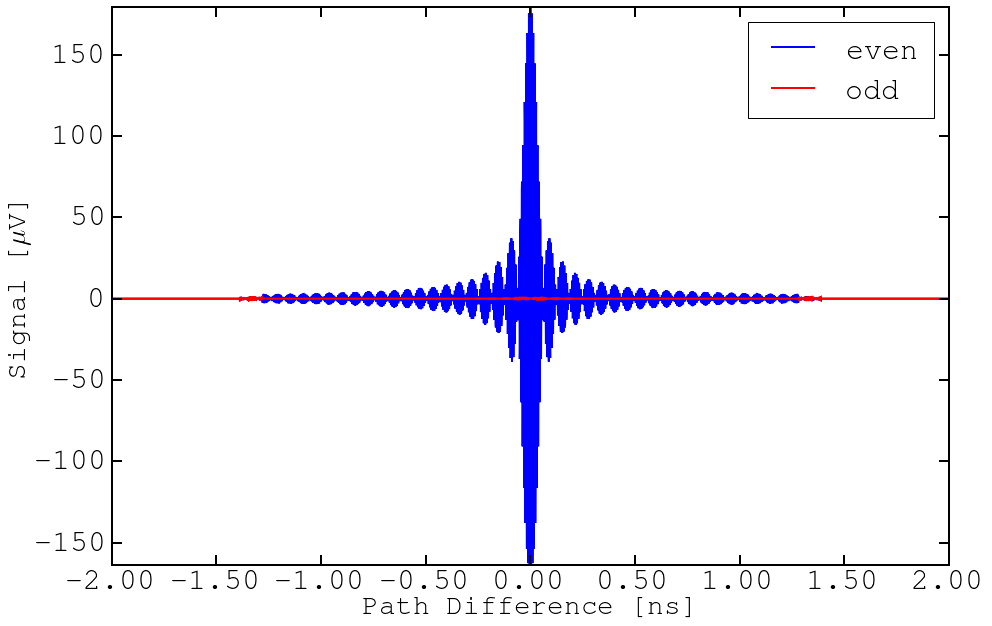

In [61]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(pdnew[1:], geteven(ynew)*1e6, 'b', label='even')
ax.plot(pdnew[1:], getodd(ynew)*1e6, 'r', label='odd')
ax.axis('tight')
ax.set_xlabel(r'Path Difference [ns]')
ax.set_ylabel(r'Signal [$\mu$V]')
ax.legend(loc='best')
ax.set_xticklabels(['{0:0.2f}'.format(t) for t in ax.get_xticks()])
ax.set_yticklabels(['{0:3.0f}'.format(t) for t in ax.get_yticks()]);

In [62]:
spectrum = fft(ynew)
freq = fftfreq(len(pdnew),  pdnew[1] - pdnew[0])
spectrum *= np.exp(1j*2*np.pi*delta*(freq - nu_0 ))
thresh = np.logical_and(freq <= 200, freq >= 100)

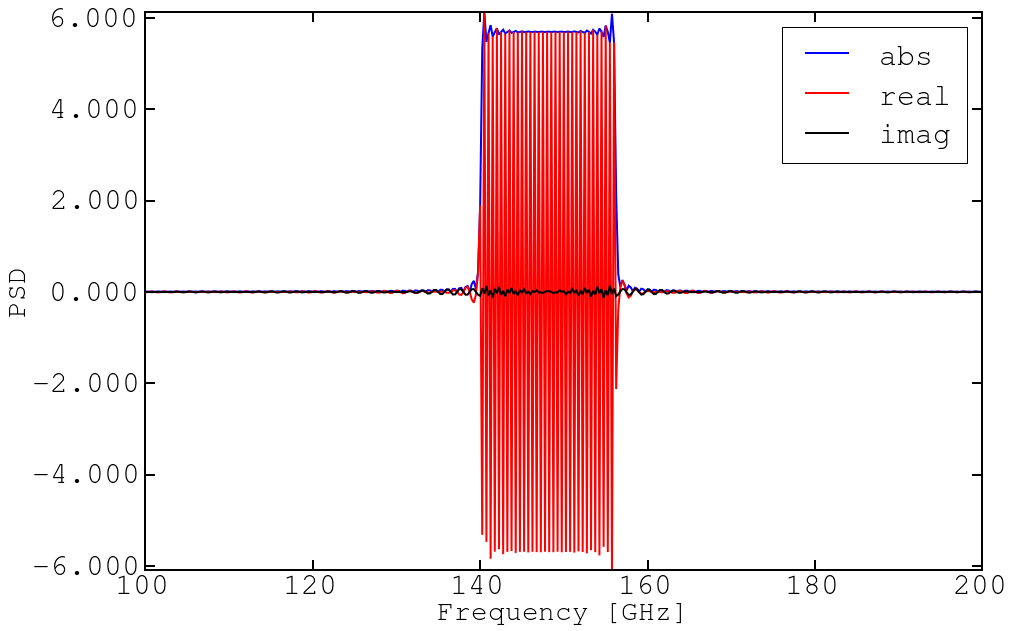

In [63]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(freq[thresh], np.abs(spectrum[thresh])*1e3, label='abs')
ax.plot(freq[thresh], np.real(spectrum[thresh])*1e3, 'r', label='real')
ax.plot(freq[thresh], np.imag(spectrum[thresh])*1e3, 'k', label='imag')
ax.axis('tight')
ax.set_xlabel(r'Frequency [GHz]')
ax.set_ylabel(r'PSD')
ax.legend(loc='best')
ax.set_xticklabels(['{0:3.0f}'.format(t) for t in ax.get_xticks()])
ax.set_yticklabels(['{0:1.3f}'.format(t) for t in ax.get_yticks()]);

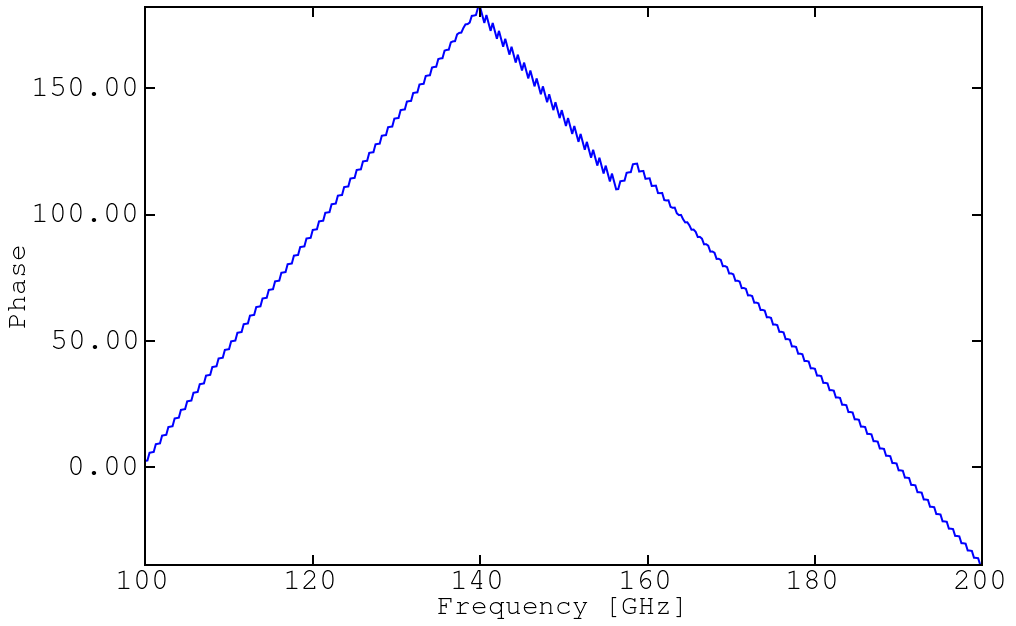

In [64]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(freq[thresh], np.unwrap(np.angle(spectrum[thresh])))
ax.axis('tight')
ax.set_xlabel(r'Frequency [GHz]')
ax.set_ylabel(r'Phase')
ax.set_xticklabels(['{0:3.0f}'.format(t) for t in ax.get_xticks()])
ax.set_yticklabels(['{0:3.2f}'.format(t) for t in ax.get_yticks()]);

In [65]:
f = (freq - nu_0)/bandwidth
rect = np.zeros_like(f)
rect[np.abs(f) < 0.5] = 1
expected = -(params[0]/(c*params[1]))*rect* np.exp(-1j*2*np.pi*delta*(freq - nu_0 ))
phase_expected = delta*2*np.pi*(freq - nu_0)

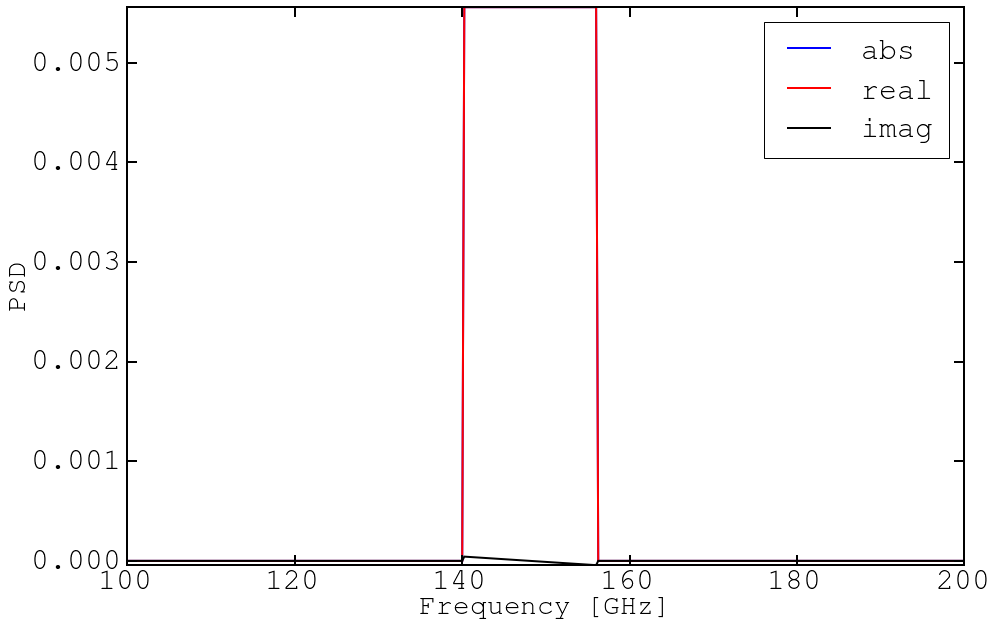

In [66]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(freq[thresh], np.abs(expected[thresh])*1e3, label='abs')
ax.plot(freq[thresh], np.real(expected[thresh])*1e3, 'r', label='real')
ax.plot(freq[thresh], np.imag(expected[thresh])*1e3, 'k', label='imag')
ax.axis('tight')
ax.set_xlabel(r'Frequency [GHz]')
ax.set_ylabel(r'PSD')
ax.legend(loc='best')
ax.set_xticklabels(['{0:3.0f}'.format(t) for t in ax.get_xticks()])
ax.set_yticklabels(['{0:1.3f}'.format(t) for t in ax.get_yticks()]);

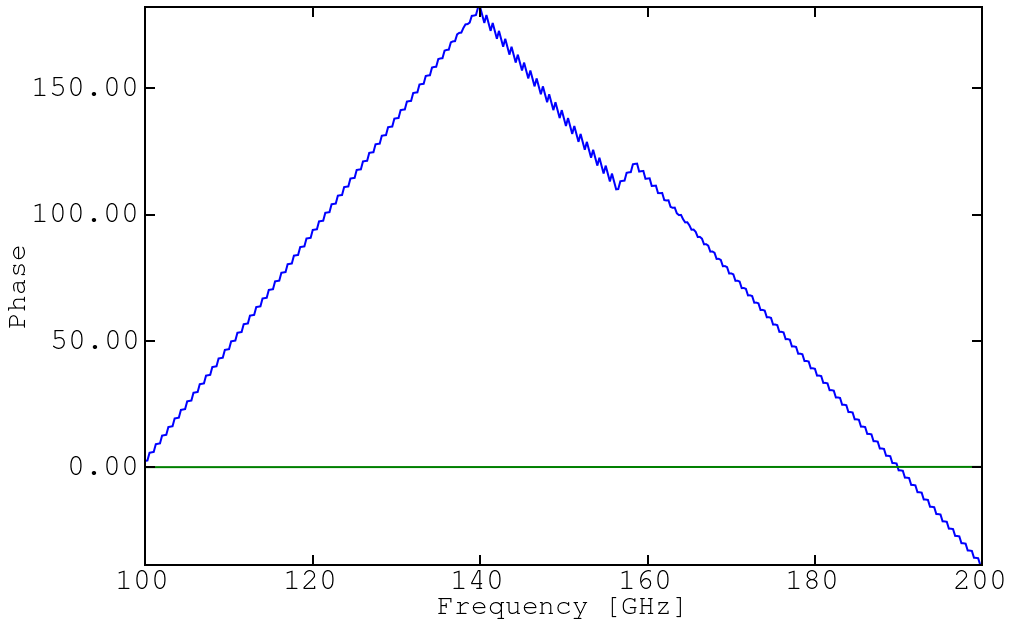

In [67]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(freq[thresh], np.unwrap(np.angle(spectrum[thresh])))
ax.plot(freq[thresh], phase_expected[thresh])
ax.axis('tight')
ax.set_xlabel(r'Frequency [GHz]')
ax.set_ylabel(r'Phase')
ax.set_xticklabels(['{0:3.0f}'.format(t) for t in ax.get_xticks()])
ax.set_yticklabels(['{0:3.2f}'.format(t) for t in ax.get_yticks()]);

The spline is an interpolating spline (fp=0)


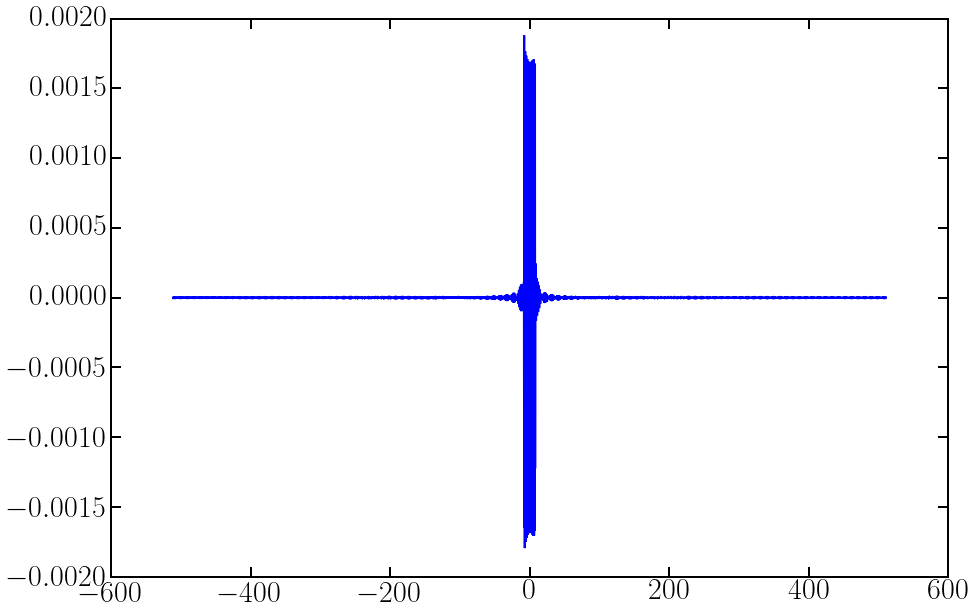

In [133]:
sinc = envelope(x, *params[:-1])
tck, fp, ier, msg = splrep(pd, sinc,w=None,k=3, task=0,s=None,full_output=True)
print (msg)
sinc_thresh = np.logical_and(freq <= 30, freq >= -30)
sinc_new = splev(pdnew, tck, der=0, ext=1)
sinc_fft = fft(sinc_new)*np.exp(-1j*2*np.pi*delta*(freq - nu_0 ))

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(freq, np.imag(sinc_fft));

The spline is an interpolating spline (fp=0)


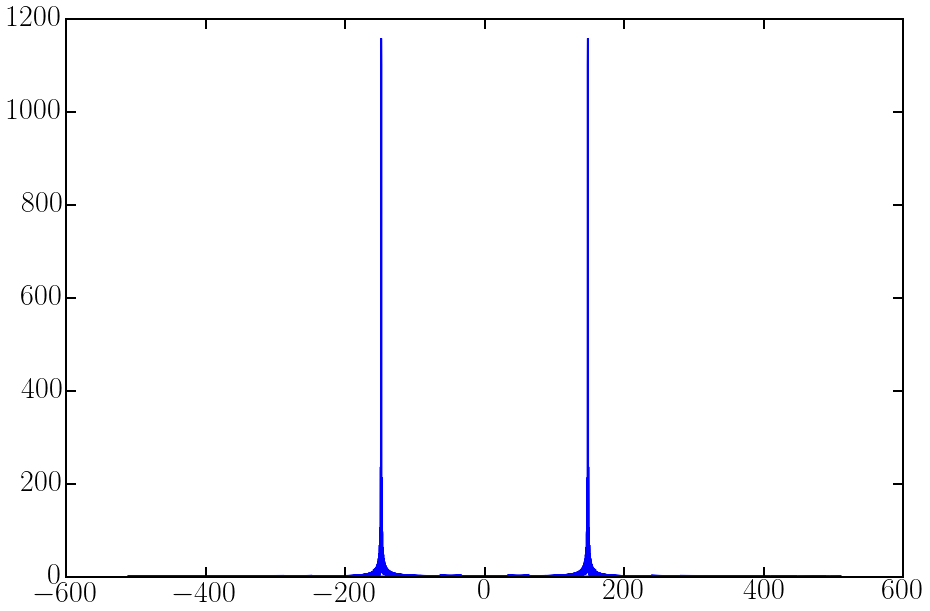

In [74]:
cos = oscillation(x, params[-1])
tck, fp, ier, msg = splrep(pd, cos,w=None,k=3, task=0,s=None,full_output=True)
print (msg)
cos_thresh = np.logical_and(freq <= 200, freq >= 100)
cos_new = splev(pdnew, tck, der=0, ext=1)
cos_fft = fft(cos_new)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(freq, np.abs(cos_fft));

4096


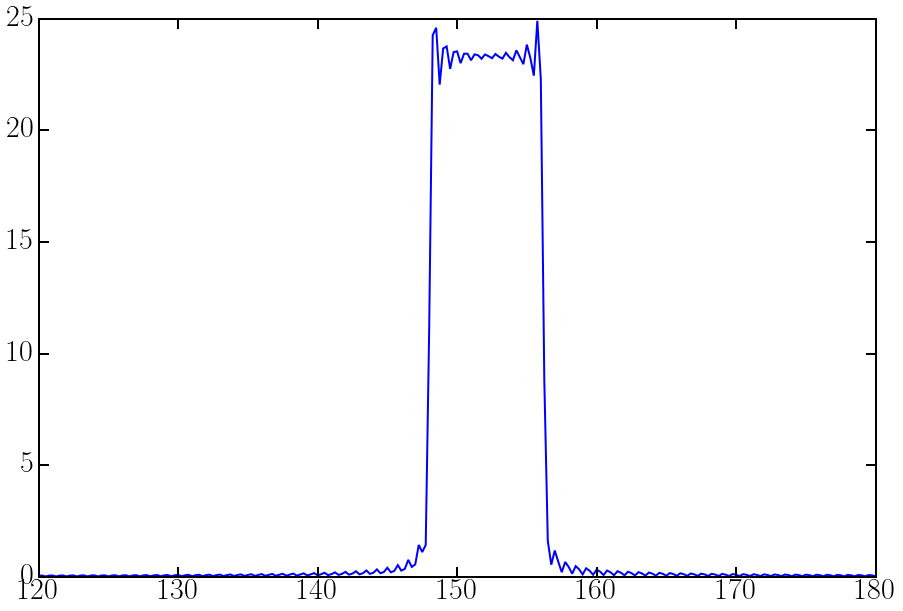

In [131]:
sinc_cos = np.convolve(cos_fft, sinc_fft, mode='full')

N  = len(cos_fft)
print (N)
conv_range = np.arange(-N, N - 1)/((pdnew[1] - pdnew[0])*N)
new_freq = np.zeros_like(conv_range)
new_freq[:N-1] = conv_range[N:]
new_freq[N-1:] = conv_range[:N]
conv_thresh = np.logical_and(new_freq >= 120, new_freq <= 180)
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(new_freq[conv_thresh], np.abs(sinc_cos)[conv_thresh]);

In [89]:
print (conv_range[0])
print (freq[n/2])

-1024.0
-512.0


In [90]:
print (conv_range[-1])
print (freq[n/2 - 1])

1023.5
511.75


In [122]:
len(sinc_cos)

8191

In [121]:
len(new_freq)

16381